# Track your Experiment Progress using Events
Running a data collection for an experiment can be an organizational challenge. Many experiments are running through different phases and keeping track of what data belongs to what phase can be one of the difficulties.

Using [events](/invisible/explainers/basic-concepts/#events), tracking the progress of an experiment becomes very easy and can often be fully automated though.

In this guide we will demonstrate how to save events at recording time and how to utilize them later during analysis to easily keep track of what phase a certain section of data was recorded in.

To this end we are assuming a minimal experiment setup: we want to record subjects while they observe a series of images of animals and analyse how the average fixation duration differs for each image.

## How to use Events to keep track?
Events are essentially timestamps within a recording that have been marked with a name. We need to keep track of when a specific image is shown during a recording, so we can associate the according fixation data with that image. Thus, we will create an event at the start and end of each image presentation to mark this section.

Events can either be created post hoc in the project editor, or at recording time using either the [real-time API](/invisible/how-tos/integrate-with-the-real-time-api/introduction) or [Pupil Invisible Monitor](/invisible/how-tos/data-collection-with-the-companion-app/monitor-your-data-collection-in-real-time). In this example we are interested in fully automating the event creation and will thus use the real-time API to save events, but depending on your use-case you could use either of those methods.

You can download the example data used in this guide [here](https://drive.google.com/file/d/1O-HJJbJWRBgcZS1sowCX2srmME5hTub0/view?usp=sharing) and find the code [here](https://github.com/pupil-labs/pupil-docs/src/invisible/how-tos/integrate-with-the-real-time-api/track-your-experiment-progress-using-events/track-your-experiment-progress-using-events.md).

## Implementation
The implementation for stimulus presentation is minimal. The images are loaded using OpenCV and are displayed in a full-screen window for fixed amount of time.

In [3]:
import time
import cv2

image_names = ["owl", "fox", "deer"]

def prepare_stimulus_presentation():
    cv2.namedWindow("Stimulus", cv2.WINDOW_NORMAL)
    cv2.setWindowProperty("Stimulus", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

def present_stimulus(img):
    presentation_time = 5
    start_time = time.perf_counter()
    while time.perf_counter() - start_time < presentation_time:
        cv2.imshow("Stimulus", img)
        cv2.waitKey(1)

def cleanup_stimulus_presentation():
    cv2.destroyAllWindows()
    

Using the real-time API, we now have to connect to a Pupil Invisible device for recording. We can remotely start the recording and save events before and after stimulus presentation. The names of the events are chosen as `<animal name>_start` and `<animal name>_end` depending on the animal that is shown.

Once all images have been shown, the recording is stopped remotely.

In [ ]:
# The 2 lines below are only needed when accessing 
# the real-time API from a Jupyter notebook
import nest_asyncio
nest_asyncio.apply()

from pupil_labs.realtime_api.simple import discover_one_device

device = discover_one_device()
device.recording_start()

# Wait for a couple seconds before starting
# to give all sensors enough time to initialize
time.sleep(3)

prepare_stimulus_presentation()

for name in image_names:
    img = cv2.imread(name + ".jpg")

    device.send_event(name + "_start")
    present_stimulus(img)    
    device.send_event(name + "_end")

cleanup_stimulus_presentation()
device.recording_stop_and_save()

That is all we have to do during data collection. Once all recordings have uploaded to Pupil Cloud, we create a project with them in order to export them using the [Raw Data Exporter](/invisible/explainer/enrichments/raw-data-exporter). In the project editor we can already see the events in every recording.

<div style="display:flex;justify-content:center;" class="pb-4">
  <v-img
    :src="require('../../../../media/invisible/how-tos/project-editor-screenshot.png')"
    max-width=100%
  >
  </v-img>
</div>

Let's look at at example event and fixation data from the raw data export.

In [1]:
import pandas as pd
events = pd.read_csv("raw-data-export/george-49e4a972/events.csv")
events

,recording id,timestamp [ns],name,type
0,49e4a972-7d6b-4b42-b931-bf64b91f952b,1644417853032000000,recording.begin,recording
1,49e4a972-7d6b-4b42-b931-bf64b91f952b,1644417856195000000,owl_start,recording
2,49e4a972-7d6b-4b42-b931-bf64b91f952b,1644417861273000000,owl_end,recording
3,49e4a972-7d6b-4b42-b931-bf64b91f952b,1644417861399000000,fox_start,recording
4,49e4a972-7d6b-4b42-b931-bf64b91f952b,1644417866475000000,fox_end,recording
5,49e4a972-7d6b-4b42-b931-bf64b91f952b,1644417866613000000,deer_start,recording
6,49e4a972-7d6b-4b42-b931-bf64b91f952b,1644417872348000000,deer_end,recording
7,49e4a972-7d6b-4b42-b931-bf64b91f952b,1644417872441000000,recording.end,recording


In [2]:
fixations = pd.read_csv("raw-data-export/george-49e4a972/fixations.csv")
fixations.head()

,section id,recording id,fixation id,start timestamp [ns],end timestamp [ns],duration [ms],fixation x [px],fixation y [px]
0,5b682999-fb7d-42c3-9da0-2253ece6299b,49e4a972-7d6b-4b42-b931-bf64b91f952b,1,1644417853698031394,1644417853910023394,211,651.751,731.750
1,5b682999-fb7d-42c3-9da0-2253ece6299b,49e4a972-7d6b-4b42-b931-bf64b91f952b,2,1644417853978009394,1644417854338008394,359,528.268,881.095
2,5b682999-fb7d-42c3-9da0-2253ece6299b,49e4a972-7d6b-4b42-b931-bf64b91f952b,3,1644417854410160394,1644417856542104394,2131,655.423,668.033
3,5b682999-fb7d-42c3-9da0-2253ece6299b,49e4a972-7d6b-4b42-b931-bf64b91f952b,4,1644417856590003394,1644417857238017394,648,523.187,677.434
4,5b682999-fb7d-42c3-9da0-2253ece6299b,49e4a972-7d6b-4b42-b931-bf64b91f952b,5,1644417857298000394,1644417858693973394,1395,772.743,640.843


We can now simply iterate through the recordings and filter the fixation data using the start and end timestamps, to calculate the average fixation duration of every image and subject.

In [6]:
import os
import json

export_folder = "raw-data-export/"

results = pd.DataFrame(columns=image_names)

for f in os.listdir(export_folder):
    rec_folder = os.path.join(export_folder, f)
    if not os.path.isdir(rec_folder):
        continue
    
    # Read all relevant files
    info_path = os.path.join(rec_folder, "info.json")
    with open(info_path) as info:
        rec_name = json.load(info)["template_data"]["recording_name"]

    events_path = os.path.join(rec_folder, "events.csv")
    events = pd.read_csv(events_path)

    fixations_path = os.path.join(rec_folder, "fixations.csv")
    fixations = pd.read_csv(fixations_path)

    # Calculate average fixation duration per recording and image
    for name in image_names:
        start_event = events[events["name"] == name + "_start"]
        start_timestamp = start_event["timestamp [ns]"].values[0]
        
        end_event = events[events["name"] == name + "_end"]
        end_timestamp = end_event["timestamp [ns]"].values[0]

        condition = (fixations["start timestamp [ns]"] >= start_timestamp) & (fixations["end timestamp [ns]"] <= end_timestamp)
        image_fixations = fixations[condition]

        results.loc[rec_name, name] = image_fixations["duration [ms]"].mean()

results.loc["Mean"] = results.mean()

results

,owl,fox,deer
George,597.714286,426.1,590.111111
Jane,667.142857,772.4,512.2
John,387.9,640.571429,664.857143
Lisa,829.8,653.714286,478.666667
Steve,583.285714,539.125,406.090909
Mean,613.168571,606.382143,530.385166


Visualized as a bar chart it looks as follows:

Text(0, 0.5, 'Average fixation duration [ms]')

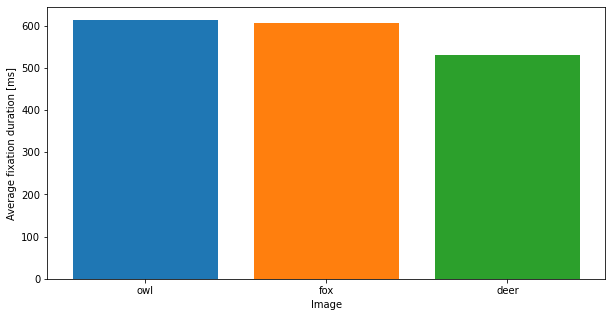

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for idx, name in enumerate(image_names):
    plt.bar(idx, results.loc["Mean", name])

plt.xticks(range(len(image_names)), image_names)
plt.xlabel("Image")
plt.ylabel("Average fixation duration [ms]")

## Conclusion
In this guide you saw how to use events to track the progress of an experiment. Note that this approach can be generalized to much more complex setups.